# "Linkage discovery between scientific articles in Python and with graphs"
> "In this article we use Python and graphs to discover linkages between scientific papers."
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, scikit-learn, nlp]

# PLOS Biology-Inspired PLOS Biology Articles

This past week I had my first encounter with the concept of [graph databases](https://en.wikipedia.org/wiki/Graph_database)
which lend themselves perfectly to modeling and capturing linked data.

I started reading the free and brilliant book [Graph Databases](http://www.graphdatabases.com/) by Robinson, Webber, and Eifrem and
began playing around with [Python bulbs](http://bulbflow.com/) by James Thornton.

I further took the data set of 1754 PLOS Biology articles that I have examined on this blog multiple times and created a
[Rexster](https://github.com/tinkerpop/rexster/wiki)-based graph database from them.
Apart from the obvious authors, DOIs, and titles I also extracted references to other PLOS Biology articles.

In this blog post I will examine these links between PLOS Biology articles.

Let us first take a look at my database to get an idea of what this looks like.

In [21]:
%matplotlib inline
from matplotlib import pyplot

In [1]:
from bulbs.rexster import Graph, Config, REXSTER_URI

In [2]:
REXSTER_URI = 'http://localhost:8182/graphs/plos'
config = Config(REXSTER_URI)

In [3]:
g = Graph(config)

The label `g` now holds a reference to our graph database.

Python bulbs allows us to define classes for our data model which is something I did when creating this graph database in the first place.
These are the node (vertex) types and edge (relationship) types I defined:

In [4]:
# Bulbs Models
from bulbs.model import Node, Relationship
from bulbs.property import String, Integer, DateTime, List

class Author(Node):
    element_type = 'author'
    name = String(nullable=False)
    
class Article(Node):
    element_type = 'article'
    title = String(nullable=False)
    published = DateTime()
    doi = String()
    
class Authorship(Relationship):
    label = 'authored'

class Citation(Relationship):
    label = 'cites'
    reference_count = Integer(nullable=False)
    tag = String()

This is a very basic model of PLOS Biology articles that captures nothing more than authorship (edges between authors and articles) and
citations (edges between articles).

Some of these concepts can and should probably be decorated further: for instance `Authorship` edges could include author contributions (as provided at the bottom of most PLOS Biology articles).

In [5]:
g.add_proxy('authors', Author)
g.add_proxy('articles', Article)
g.add_proxy('authored', Authorship)
g.add_proxy('cites', Citation)

Usually we would use Rexster/Bulbs-builtin functions that rely on some internal index but since that index seems to be broken for me right now
I will simply collect all nodes and edges by hand and create Python dictionaries as indeces.

This is okay here to do since our database is very small but would likely be prohibitive for anything marginally bigger.

In [6]:
nodes = g.V
edges = g.E

In [7]:
authors = {n.name: n for n in nodes if n.element_type == 'author'}

In [8]:
authors.keys()[:10]

[u'Shuguang Zhang',
 u'Ernst Hafen',
 u'Maren Brockmeyer',
 u'Bruno Eschli',
 u'David B. Gurevich',
 u'Michael Lynch',
 u'Alejandro Valbuena',
 u'Claudia Rutte',
 u'Matthew M Wyatt',
 u'Brianna B. Williams']

In [9]:
articles = {n.doi: n for n in nodes if n.element_type == 'article'}

In [10]:
articles.keys()[:10]

[u'10.1371/journal.pbio.0040216',
 u'10.1371/journal.pbio.0040215',
 u'10.1371/journal.pbio.0040210',
 u'10.1371/journal.pbio.0040368',
 u'10.1371/journal.pbio.0040369',
 u'10.1371/journal.pbio.0040362',
 u'10.1371/journal.pbio.0040363',
 u'10.1371/journal.pbio.0040360',
 u'10.1371/journal.pbio.0020275',
 u'10.1371/journal.pbio.0040366']

Let us now do a brief sanity check and count the number of PLOS Biology articles in our data set (this should equal 1754).

In [11]:
len(articles.keys())

1754

Let us now pick an article at random and see how this article is connected to the remainder of the graph.

In [12]:
article = articles['10.1371/journal.pbio.1000584']

This is the title of `article`:

In [13]:
article.title

u'Clusters of Temporal Discordances Reveal Distinct Embryonic Patterning Mechanisms in Drosophila and Anopheles'

These are the edges pointing to this article:

In [14]:
list(article.inE())

[<Authorship: http://localhost:8182/graphs/plos/edges/21895>,
 <Authorship: http://localhost:8182/graphs/plos/edges/21893>,
 <Authorship: http://localhost:8182/graphs/plos/edges/21891>]

There are three `Authorship` edges that point to this specific article.

To get the node at the *base* of a directed edge we can either query `article.inE().inV()` (i.e. the *in-node* of this edge)
or simply ask for the *in-node* of the `article` node straight away - this should be equivalent!

In [15]:
for author in article.inV():
    print author.name

Yury Goltsev
Michael Levine
Dmitri Papatsenko


A quick check online confirms that these are indeed the authors of `article`.

As I mentioned above, I also collected all references to other PLOS Biology articles in my data set and modeled those as `Citation` relationships (edges) between articles.

The `article` we are currently looking at has one such out-edge to another PLOS Biology article:

In [16]:
list(article.outE())

[<Citation: http://localhost:8182/graphs/plos/edges/29290>]

In [17]:
for citation in article.outV():
    print citation.title
    print [n.name for n in citation.inV() if n.element_type == 'author']
    print citation.doi

The Cell Cycle–Regulated Genes of Schizosaccharomyces pombe
[u'Saumyadipta Pyne', u'Janet Leatherwood', u'Anna Oliva', u'Bruce Futcher', u'Adam Rosebrock', u'Steve Skiena', u'Francisco Ferrezuelo', u'Haiying Chen']
10.1371/journal.pbio.0030225


As you can see above, querying our database for the authors of the PLOS Biology article that our current article (`article`) cites is simple.

How many PLOS Biology articles in our data set of 1754 articles cite other PLOS Biology articles?

(caveat: this only represents those citations that I detected when parsing my set of articles)

In [18]:
sum(1 for n in nodes if n.element_type == 'article' and n.outV() > 0)

526

I did not only extract citation edges between PLOS Biology articles but also counted how often such a citation occurs in the body of the article.

For our `article` and its one cited PLOS Biology article I counted:

In [19]:
for citation in article.outE():
    print citation.reference_count

2


Just to verify this, look up `article` online (DOI = 10.1371/journal.pbio.0030225) and look for reference *[4]* which corresponds to this one cited PLOS Biology article.

Let us now take a look at the observed distribution of how often cited PLOS Biology articles are referenced in the main text of the citing PLOS Biology article.

In [23]:
citation_counts = []
for doi in articles.keys():
    if articles[doi].outE():
        for e in articles[doi].outE():
            if e.label == 'cites':
                citation_counts.append(e.reference_count)

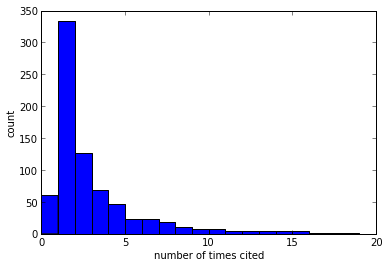

In [28]:
pyplot.hist(citation_counts, bins=range(20))
pyplot.xlabel('number of times cited')
pyplot.ylabel('count')

This histogram has a surprisingly long tail. Let us take a look at some of the bigger values to see if these make sense.

In [69]:
def article_pp(article):
    authors = unicode(', '.join([n.name for n in article.inV() if n.element_type == 'author']))
    s = ('Title: %s\n'
        'Authors: %s\n'
        'DOI: %s' % (article.title, authors, article.doi))
    
    return s

In [75]:
for edge in edges:
    if edge.label == 'cites':
        if edge.reference_count >= 21:
            print('Citer:')
            print(article_pp(edge.outV()))
            print('')
            print('Citee')
            print(article_pp(edge.inV()))
            print('')
            print('Citer cites citee %d times.' % edge.reference_count)
            print('-----------------------------------------------------')

Citer:
Title: A Feedback Loop between Dynamin and Actin Recruitment during Clathrin-Mediated Endocytosis
Authors: Marko Lampe, Christien J. Merrifield, Marcus J. Taylor
DOI: 10.1371/journal.pbio.1001302

Citee
Title: A High Precision Survey of the Molecular Dynamics of Mammalian Clathrin-Mediated Endocytosis
Authors: Marcus J. Taylor, David Perrais, Christien J. Merrifield
DOI: 10.1371/journal.pbio.1000604

Citer cites citee 21 times.
-----------------------------------------------------
Citer:
Title: H2A.Z-Mediated Localization of Genes at the Nuclear Periphery Confers Epigenetic Memory of Previous Transcriptional State 
Authors: Yvonne Fondufe-Mittendorf, Sara Ahmed, Jason H Brickner, Donna Garvey Brickner, Jonathan Widom, Ivelisse Cajigas, Pei-Chih Lee
DOI: 10.1371/journal.pbio.0050081

Citee
Title: Gene Recruitment of the Activated INO1 Locus to the Nuclear Membrane
Authors: Peter Walter, Jason H Brickner
DOI: 10.1371/journal.pbio.0020342

Citer cites citee 21 times.
--------------

Checking these by hand we verify that our counts are correct.

I think it is sensible to postulate that the more often one article cites another one, the more heavily the work presented in the *citer* was influenced by the *citee*.

There is certainly some cut-off at which *importance* stops increasing - my point is simply that citing another article multiple times in your manuscript probably means that you are basing your work at least partially on the article you cite.

In the above list we can already see that one article titled *A sex-ratio Meiotic Drive System in Drosophila simulans. II: An X-linked Distorter* is a clear follow-up to the article titled *A sex-ratio Meiotic Drive System in Drosophila simulans. I: An Autosomal Suppressor*.

One question I am interested in is: How inspired are authors by their own work (generally *very inspired* I would presume), and how inspiring are articles to a completely different group of authors?

In my opinion, if one group of authors inspires a completely different group of authors to carry out scientific work (be it to follw up, refute, or whatever) then that defines *knowledge transfer* and a point at which scientific knowledge really becomes worth the time and resources it cost to produce this knowledge in the first place.

(I am certain this statement can be refined further but roughly speaking this is what I think)

Let us redo the above histogram but exclude all cited PLOS Biology articles that have one or more authors in common with the citing article.

(one more bracketed caveat: When constructing my database I assumed that every author name occurs exactly once and is therefore unique - this is a heuristic that breaks easily)

In [63]:
def are_different_authors(article_1, article_2):
    authors_1 = []
    authors_2 = []
    
    for n in article_1.inV():
        if n.element_type == 'author':
            authors_1.append(n.name)
    for n in article_2.inV():
        if n.element_type == 'author':
            authors_2.append(n.name)
            
    authors_1 = set(authors_1)
    authors_2 = set(authors_2)
    
    return len(authors_1.intersection(authors_2)) == 0


In [64]:
citation_counts = []

for edge in edges:
    if edge.label == 'cites':
        if are_different_authors(edge.inV(), edge.outV()):
            citation_counts.append(edge.reference_count)

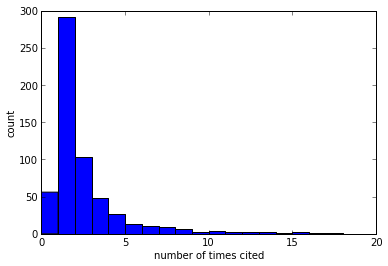

In [65]:
pyplot.hist(citation_counts, bins=range(20))
pyplot.xlabel('number of times cited')
pyplot.ylabel('count')

This histogram does not look very different from the one above.

Let us take a look at data points in the tail:

In [74]:
for edge in edges:
    if edge.label == 'cites':
        if edge.reference_count >= 16 and are_different_authors(edge.inV(), edge.outV()):
            print('Citer:')
            print(article_pp(edge.outV()))
            print('')
            print('Citee')
            print(article_pp(edge.inV()))
            print('')
            print('Citer cites citee %d times.' % edge.reference_count)
            print('-----------------------------------------------------')

Citer:
Title: Lack of Support for the Association between GAD2 Polymorphisms and Severe Human Obesity
Authors: Frank Geller, John P Kane, Raphael Merriman, Christian Vaisse, Winfried Rief, Robert Dent, Johannes Hebebrand, Björn Waldenmaier, Franck Mauvais-Jarvis, Anke Hinney, Michael M Swarbrick, Clive R Pullinger, Mary Malloy, Len A Pennacchio, Anna Ustaszewska, Denise L Lind, Wen-Chi Hsueh, Ruth McPherson, Martha M Cavazos, André Scherag, Pui-Yan Kwok
DOI: 10.1371/journal.pbio.0030315

Citee
Title: GAD2 on Chromosome 10p12 Is a Candidate Gene for Human Obesity
Authors: Lynn Bekris, Valérie Vasseur-Delannoy, Philippe Boutin, Karin Séron, Philippe Froguel, Mohamed Chikri, Christian Dina, Laetitia Corset, M. Aline Charles, Séverine Dubois, Francis Vasseur, Janice Cabellon, Ake Lernmark, Bernadette Neve, Karine Clement
DOI: 10.1371/journal.pbio.0000068

Citer cites citee 17 times.
-----------------------------------------------------
Citer:
Title: Structural Basis of Rap Phosphatase Inhi

As we can see the two article pairs in the tail of this updated distribution are linked with lower reference counts than what we observed before filtering for author disjointedness.

Now, how inspiring are PLOS Biology authors for other (different) PLOS Biology authors?

To answer this question, I would like to propose a measure that I have called **Inspiration Factor** in my own head for some time now and one variant of the model I have had in mind is this:

Inspiration is an increasing function of the number of authors (unrelated to you) that you inspired to carry out scientific work.

Since I do not want to count citations that are mentioned only once in the main text of an article, I will impose a threshold of at least *three references*.

I should refine the way I parse articles to account for the context that citations are referenced in.

Anyways, let us take a look at those PLOS Biology articles that have inspired at least three other PLOS Biology articles.

In [99]:
inspirators = []

for article in articles.values():
    in_nodes = []
    if article.inE():
        for edge in article.inE():
            if edge.label == 'cites':
                if are_different_authors(edge.inV(), edge.outV()) and edge.reference_count >= 3:
                    in_nodes.append([edge.outV(), edge.reference_count])
                    
    if len(in_nodes) >= 3:
        inspirators.append([article, in_nodes])

In [100]:
len(inspirators)

2

In [101]:
for inspirator in inspirators:
    print('Inspirator')
    print article_pp(inspirator[0])
    print('')
    for el in inspirator[1]:
        print('Inspired Article')
        print article_pp(el[0])
        print('Cites inspirator %d times.' % el[1])
        print('')
    print('--------------------------------------')
    print('')

Inspirator
Title: The Evolution of Combinatorial Gene Regulation in Fungi
Authors: Alexander D Johnson, Aaron D Hernday, Hao Li, Brian B Tuch, David J Galgoczy
DOI: 10.1371/journal.pbio.0060038

Inspired Article
Title: Biofilm Matrix Regulation by Candida albicans Zap1
Authors: Oliver R. Homann, Clarissa J. Nobile, Jean-Sebastien Deneault, Aaron P. Mitchell, Andre Nantel, Aaron D. Hernday, David R. Andes, Jeniel E. Nett, Alexander D. Johnson
DOI: 10.1371/journal.pbio.1000133
Cites inspirator 3 times.

Inspired Article
Title: Evolutionary Tinkering with Conserved Components of a Transcriptional Regulatory Network
Authors: Jaideep Mallick, Adnane Sellam, Hugo Lavoie, Hervé Hogues, Malcolm Whiteway, André Nantel
DOI: 10.1371/journal.pbio.1000329
Cites inspirator 6 times.

Inspired Article
Title: Evolution of Phosphoregulation: Comparison of Phosphorylation Patterns across Yeast Species
Authors: Assen Roguev, Dorothea Fiedler, Jonathan C. Trinidad, Wendell A. Lim, Pedro Beltrao, Kevan M. S

And that is it for now.

I will expand my dataset to include more articles and think about how to enrich the data I extract from these articles.

One question that I am very intrigued to tackle soon is: How long of a chain of scientific discovery do you trigger?

I imagine that an article that lies at the beginning of a long chain of articles that inspired one another would have some significance.